# Mini-project

In [1]:
import numpy as np
import pandas as pd
# import seaborn as sb
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
from scipy.stats import spearmanr
from statsmodels.tsa.stattools import adfuller
import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import sys
import warnings
if not sys.warnoptions:
	warnings.simplefilter("ignore")


## Reading Data & Cleaning

### Reading
- Reading Nasdaq Price data from "./datasets/index.csv"
- Data is from investing.com(https://www.investing.com/indices/nq-100)

In [2]:
data = pd.read_csv("./datasets/Nasdaq100.csv")
data

,Date,Price,Open,High,Low,Vol.,Change %
0,03/31/2023,"13,181.35","12,969.53","13,187.74","12,969.53",317.30M,1.68%
1,03/30/2023,"12,963.14","12,937.17","12,986.51","12,894.17",222.52M,0.91%
2,03/29/2023,"12,846.03","12,768.14","12,867.32","12,735.07",269.29M,1.87%
3,03/28/2023,"12,610.57","12,654.56","12,654.56","12,517.87",202.21M,-0.49%
4,03/27/2023,"12,673.07","12,800.53","12,838.71","12,648.14",224.72M,-0.74%
...,...,...,...,...,...,...,...
1316,01/08/2018,"6,676.63","6,651.68","6,680.32","6,649.20",150.38M,0.35%
1317,01/05/2018,"6,653.29","6,613.12","6,654.98","6,605.03",152.65M,1.04%
1318,01/04/2018,"6,584.58","6,595.75","6,603.17","6,576.92",153.92M,0.13%
1319,01/03/2018,"6,575.80","6,520.03","6,579.25","6,519.26",170.11M,0.99%


### Cleaning the data
- sorting the data from earliest to latest
- using date as index

In [3]:
# Cleaning Date: Change the `dtype` to `datetime64[ns]`
data['Date'] = pd.to_datetime(data.Date,format='%m/%d/%Y')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321 entries, 0 to 1320
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1321 non-null   datetime64[ns]
 1   Price     1321 non-null   object        
 2   Open      1321 non-null   object        
 3   High      1321 non-null   object        
 4   Low       1321 non-null   object        
 5   Vol.      1321 non-null   object        
 6   Change %  1321 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 72.4+ KB


In [4]:
# Sort the data using date from old to new
data = data.sort_values(by="Date").reset_index(drop=True)
data

,Date,Price,Open,High,Low,Vol.,Change %
0,2018-01-02,"6,511.34","6,431.59","6,513.02","6,417.75",149.67M,1.80%
1,2018-01-03,"6,575.80","6,520.03","6,579.25","6,519.26",170.11M,0.99%
2,2018-01-04,"6,584.58","6,595.75","6,603.17","6,576.92",153.92M,0.13%
3,2018-01-05,"6,653.29","6,613.12","6,654.98","6,605.03",152.65M,1.04%
4,2018-01-08,"6,676.63","6,651.68","6,680.32","6,649.20",150.38M,0.35%
...,...,...,...,...,...,...,...
1316,2023-03-27,"12,673.07","12,800.53","12,838.71","12,648.14",224.72M,-0.74%
1317,2023-03-28,"12,610.57","12,654.56","12,654.56","12,517.87",202.21M,-0.49%
1318,2023-03-29,"12,846.03","12,768.14","12,867.32","12,735.07",269.29M,1.87%
1319,2023-03-30,"12,963.14","12,937.17","12,986.51","12,894.17",222.52M,0.91%


In [5]:
# Replace the index using date
data.index = data['Date']
data

,Date,Price,Open,High,Low,Vol.,Change %
Date,,,,,,,
2018-01-02,2018-01-02,"6,511.34","6,431.59","6,513.02","6,417.75",149.67M,1.80%
2018-01-03,2018-01-03,"6,575.80","6,520.03","6,579.25","6,519.26",170.11M,0.99%
2018-01-04,2018-01-04,"6,584.58","6,595.75","6,603.17","6,576.92",153.92M,0.13%
2018-01-05,2018-01-05,"6,653.29","6,613.12","6,654.98","6,605.03",152.65M,1.04%
2018-01-08,2018-01-08,"6,676.63","6,651.68","6,680.32","6,649.20",150.38M,0.35%
...,...,...,...,...,...,...,...
2023-03-27,2023-03-27,"12,673.07","12,800.53","12,838.71","12,648.14",224.72M,-0.74%
2023-03-28,2023-03-28,"12,610.57","12,654.56","12,654.56","12,517.87",202.21M,-0.49%
2023-03-29,2023-03-29,"12,846.03","12,768.14","12,867.32","12,735.07",269.29M,1.87%


### Pick up `Price` and rename the column to `Nasdaq100`

In [6]:
data = data[["Price"]]
data = data.rename(columns={"Price": "Nasdaq100"})
data.info()
data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1321 entries, 2018-01-02 to 2023-03-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Nasdaq100  1321 non-null   object
dtypes: object(1)
memory usage: 20.6+ KB


,Nasdaq100
Date,
2018-01-02,"6,511.34"
2018-01-03,"6,575.80"
2018-01-04,"6,584.58"
2018-01-05,"6,653.29"
2018-01-08,"6,676.63"
...,...
2023-03-27,"12,673.07"
2023-03-28,"12,610.57"
2023-03-29,"12,846.03"


### Change the Dtype of `Nasdaq100` to `float`

In [7]:
data['Nasdaq100'] = pd.to_numeric(data['Nasdaq100'].str.replace(',', ''))
data['Nasdaq100'] = data['Nasdaq100'].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1321 entries, 2018-01-02 to 2023-03-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Nasdaq100  1321 non-null   float64
dtypes: float64(1)
memory usage: 20.6 KB


## Create `original_data` for keeping the original data unchanged and untouched

In [8]:
original_data = data
original_data

,Nasdaq100
Date,
2018-01-02,6511.34
2018-01-03,6575.80
2018-01-04,6584.58
2018-01-05,6653.29
2018-01-08,6676.63
...,...
2023-03-27,12673.07
2023-03-28,12610.57
2023-03-29,12846.03


# Exploratory Data Analysis


## All-time High & Low of Nasdaq100

In [9]:
eda_data = original_data.copy()
print("All time high:\n", eda_data.query("Nasdaq100 == Nasdaq100.max()"))
print("All time low:\n", eda_data[eda_data.Nasdaq100 == eda_data.Nasdaq100.min()])

eda_data.describe()

All time high:
             Nasdaq100
Date                 
2021-11-19   16573.34
All time low:
             Nasdaq100
Date                 
2018-12-24    5899.35


,Nasdaq100
count,1321.000000
mean,10507.844534
std,3029.628099
min,5899.350000
25%,7513.850000
50%,10896.470000
75%,12940.780000
max,16573.340000


## Longest consecutive days of Nasdaq100 Growth

In [10]:
eda_data['is_increasing'] = eda_data['Nasdaq100'].diff().lt(0).cumsum()

sizes = eda_data.groupby('is_increasing')['Nasdaq100'].transform('size')
eda_data[sizes == sizes.max()]

,Nasdaq100,is_increasing
Date,,
2019-12-10,8354.29,220
2019-12-11,8402.61,220
2019-12-12,8466.89,220
2019-12-13,8487.71,220
2019-12-16,8570.33,220
2019-12-17,8575.70,220
2019-12-18,8580.62,220
2019-12-19,8641.29,220
2019-12-20,8678.49,220




- All-time Low and High, Lowest at \$5899.35 on 24 Dec 2018 and Highest at \$16573.34 on 19 Nov 2021.
- Price Distribution, Most frequent price range was between 7000 to 8000.
- Longest day streak of growth was 12 Days between 10 Dec 2019 - 26 Dec 2019.


## Plot: Full data set

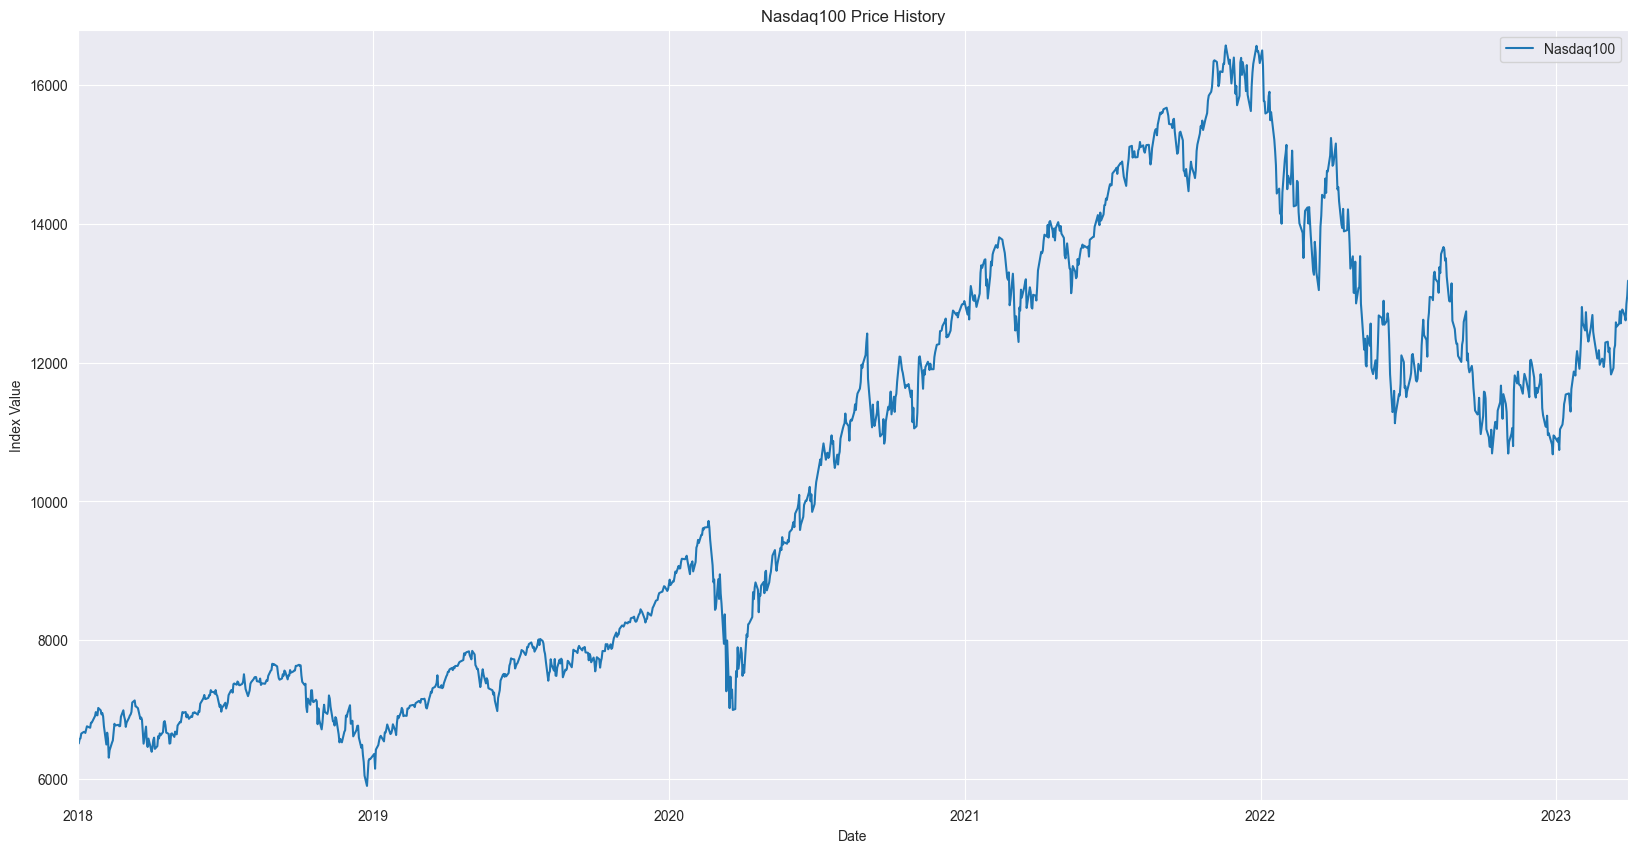

In [11]:
plt.figure(figsize=(20,10))
plt.grid()
dstart = datetime.datetime(2018,1,1)
dstop = datetime.datetime(2023,3,31)
plt.ylim(5700,16800)
plt.xlim(dstart,dstop)
plt.plot(original_data["Nasdaq100"], label='Nasdaq100')
plt.title('Nasdaq100 Price History')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.grid(True)
plt.legend()
plt.show()

## Plot: Test cases
- We use data from `2023-01-03` to `2023-03-31`.
- The first three month of this year.
- There are `62` data in total, by counting.

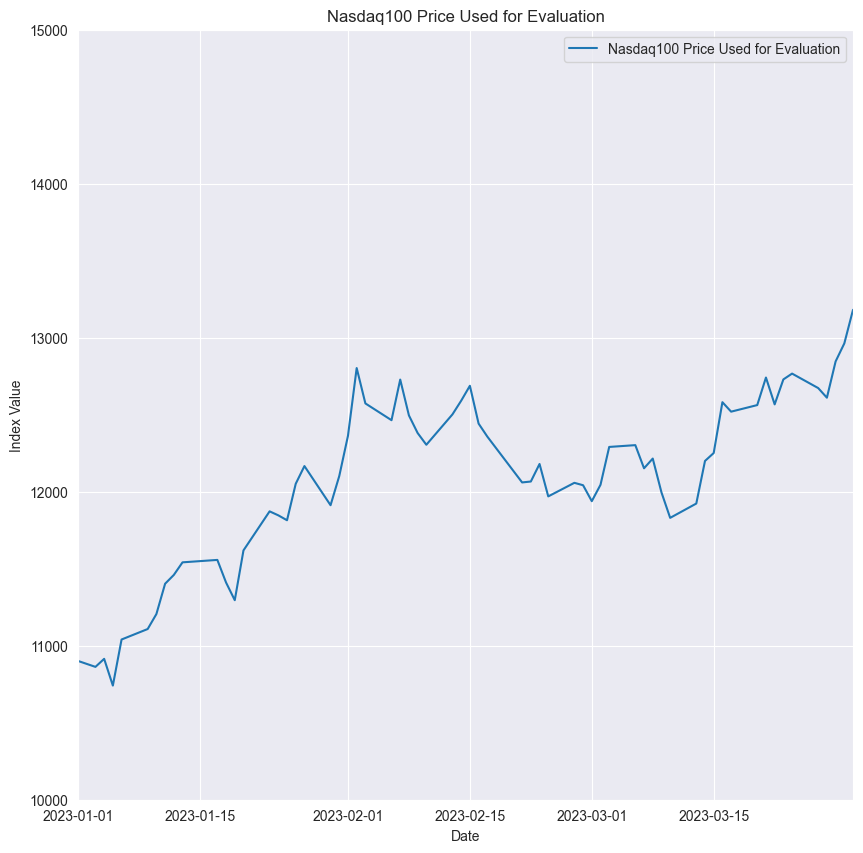

In [12]:
plt.figure(figsize=(10,10))
plt.grid()
dstart = datetime.datetime(2023,1,1)
dstop = datetime.datetime(2023,3,31)
plt.ylim(10000,15000)
plt.xlim(dstart,dstop)
plt.plot(original_data["Nasdaq100"], label='Nasdaq100 Price Used for Evaluation')
plt.title('Nasdaq100 Price Used for Evaluation')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.grid(True)
plt.legend()
plt.show()

## Moving Average on test cases using 10 days period
- We use MA to describe the trend of the test data.

In [13]:
#10 days for calculation 62 days for the trend, total 72
MAdata = original_data[-72:]

periods = 10

MAdata['moving_avg_10'] = MAdata['Nasdaq100'].rolling(window=periods).mean()
MAdata = MAdata[-62:]
mae = mean_absolute_error(MAdata['Nasdaq100'], MAdata['moving_avg_10'])
mape = mean_absolute_percentage_error(MAdata['Nasdaq100'], MAdata['moving_avg_10'])
rmse = np.sqrt(mean_squared_error(MAdata['Nasdaq100'], MAdata['moving_avg_10']))

print("MA, periods = 10")
print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')
MAdata

MA, periods = 10
mae: 241.34387096774188
mape: 0.019868363791661545
rmse: 282.62319241435904


,Nasdaq100,moving_avg_10
Date,,
2023-01-03,10862.64,10958.978
2023-01-04,10914.80,10941.999
2023-01-05,10741.22,10908.879
2023-01-06,11040.35,10889.326
2023-01-09,11108.45,10904.557
...,...,...
2023-03-27,12673.07,12559.293
2023-03-28,12610.57,12600.371
2023-03-29,12846.03,12659.842


## Plot: Original trend vs Moving Average(10)

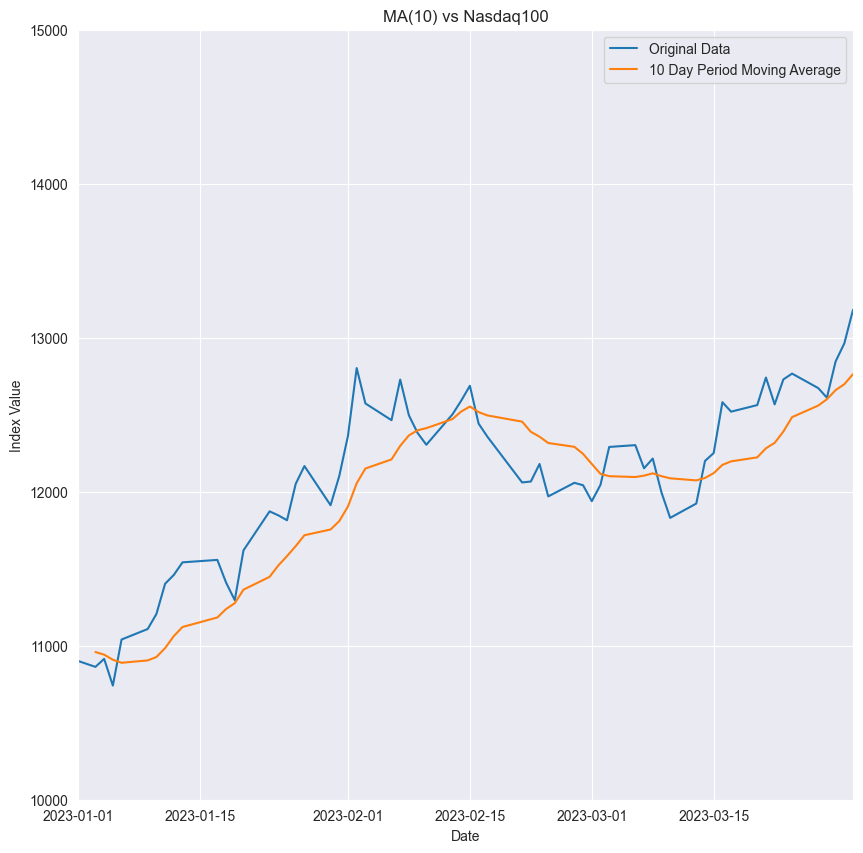

In [14]:
# Plot the original data and the moving average
plt.figure(figsize=(10,10))
plt.title('MA(10) vs Nasdaq100')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.grid(True)
dstart = datetime.datetime(2023,1,1)
dstop = datetime.datetime(2023,3,31)
plt.ylim(10000,15000)
plt.xlim(dstart,dstop)
plt.plot(data['Nasdaq100'],  label='Original Data')
plt.plot(MAdata['moving_avg_10'], label=f'{periods} Day Period Moving Average')
plt.legend()
plt.show()

## Use `peridiods=6` for MA

In [15]:
MAdata = data[-72:]

periods = 6

MAdata['moving_avg_6'] = MAdata['Nasdaq100'].rolling(window=periods).mean()

MAdata = MAdata[-62:]
mae = mean_absolute_error(MAdata['Nasdaq100'], MAdata['moving_avg_6'])
mape = mean_absolute_percentage_error(MAdata['Nasdaq100'], MAdata['moving_avg_6'])
rmse = np.sqrt(mean_squared_error(MAdata['Nasdaq100'], MAdata['moving_avg_6']))

print("MA, periods = 6")
print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')
MAdata

MA, periods = 6
mae: 174.3687096774193
mape: 0.014357932197381936
rmse: 209.58997519585355


,Nasdaq100,moving_avg_6
Date,,
2023-01-03,10862.64,10873.458333
2023-01-04,10914.80,10861.683333
2023-01-05,10741.22,10848.135000
2023-01-06,11040.35,10908.303333
2023-01-09,11108.45,10934.536667
...,...,...
2023-03-27,12673.07,12673.425000
2023-03-28,12610.57,12681.418333
2023-03-29,12846.03,12698.850000


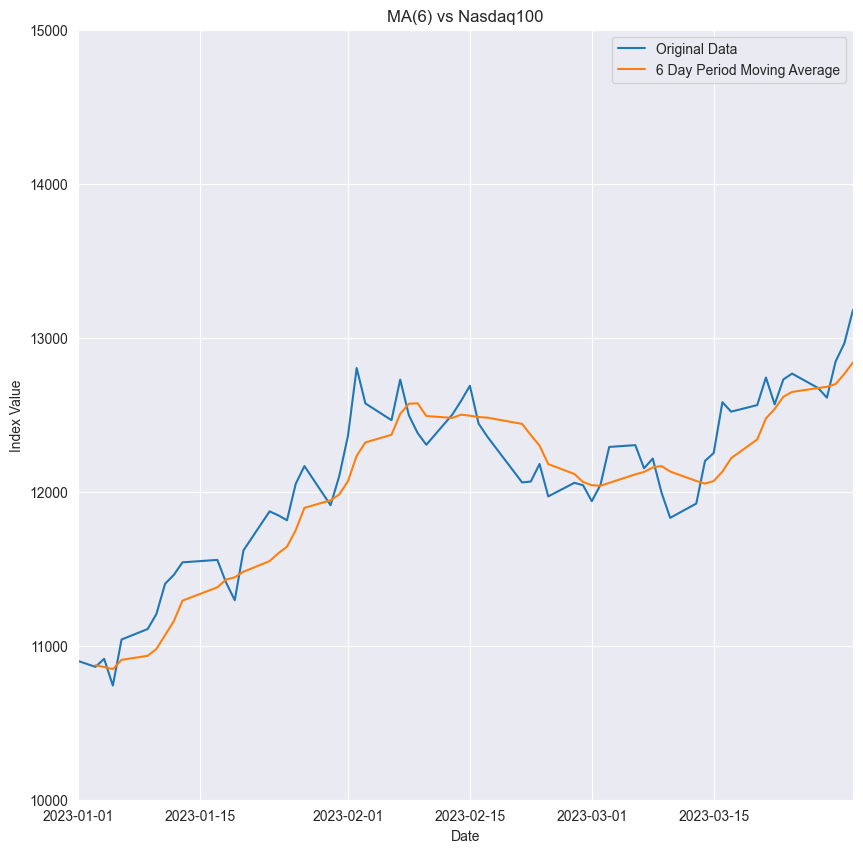

In [16]:
# Plot the original data and the moving average
plt.figure(figsize=(10,10))
plt.title('MA(6) vs Nasdaq100')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.grid(True)
dstart = datetime.datetime(2023,1,1)
dstop = datetime.datetime(2023,3,31)
plt.ylim(10000,15000)
plt.xlim(dstart,dstop)
plt.plot(data['Nasdaq100'],  label='Original Data')
plt.plot(MAdata['moving_avg_6'], label=f'{periods} Day Period Moving Average')
plt.legend()
plt.show()

## We choose MA(6)

`MA, periods = 10`
`mae: 241.34387096774188`
`mape: 0.019868363791661545`
`rmse: 282.62319241435904`

`MA, periods = 6`
`mae: 174.3687096774193`
`mape: 0.014357932197381936`
`rmse: 209.58997519585355`

- For `MAE`, `MAPE`, `RMSE`, the smaller the better. That means the tested dataset(`"moving_avg"` in this case) has smaller error with the original dataset.
- `MA(6)` has smaller error, and by observation, its curve more closely matches the true value curve.
- So we choose `MA(6)` as `MAdata`.

In [17]:
moving_avg = MAdata["moving_avg_6"]
moving_avg

Date
2023-01-03    10873.458333
2023-01-04    10861.683333
2023-01-05    10848.135000
2023-01-06    10908.303333
2023-01-09    10934.536667
                  ...     
2023-03-27    12673.425000
2023-03-28    12681.418333
2023-03-29    12698.850000
2023-03-30    12764.848333
2023-03-31    12840.201667
Name: moving_avg_6, Length: 62, dtype: float64

In [18]:
MA_use = MAdata[["moving_avg_6"]]
MA_use

,moving_avg_6
Date,
2023-01-03,10873.458333
2023-01-04,10861.683333
2023-01-05,10848.135000
2023-01-06,10908.303333
2023-01-09,10934.536667
...,...
2023-03-27,12673.425000
2023-03-28,12681.418333
2023-03-29,12698.850000


## CHECK THE STATIONARITY OF THE TIME SERIES
Before applying any statistical model on a time series, we want to ensure that it is stationary. We have applied 3 methods to check the stationarity of a data.

## METHOD 1: By observing the timeseries plot

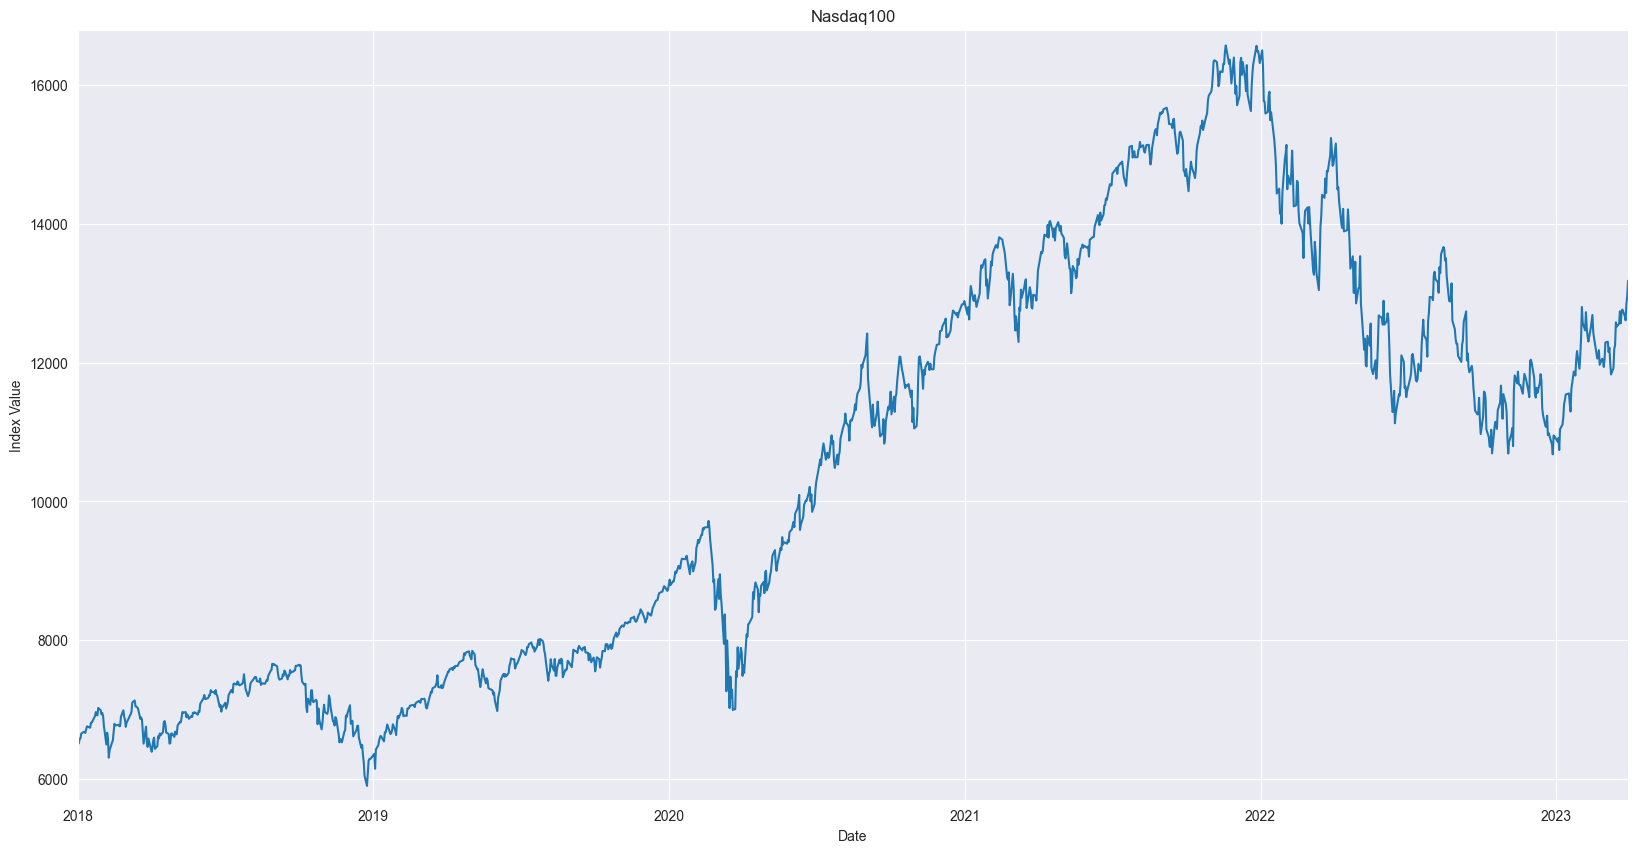

In [19]:
# plot the stock index variable
plt.figure(figsize=(20,10))

dstart = datetime.datetime(2018,1,1)
dstop = datetime.datetime(2023,3,31)
plt.ylim(5700,16800)
plt.xlim(dstart,dstop)
plt.plot(original_data["Nasdaq100"], label='Nasdaq100')

# customize the plot
plt.title('Nasdaq100')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.grid(True)

# display the plot
plt.show()

By observing with naked eye, we can see that the timeseries fluctuates overtime, there is an obvious upward, indicating that the mean is not constant over time. Hence, the time series is not stationary.

## Method 2: ADF test

In [20]:
adf_test = adfuller(original_data['Nasdaq100'])
print(f'p-value: {adf_test[1]}')

p-value: 0.6908418544160563


A p-value of 0.6909 suggests that we cannot reject the null hypothesis that the time series is non-stationary. This means that there is evidence that the data has a unit root, which indicates that the time series is likely non-stationary.

## Method 3: ACF plot and PACF plot

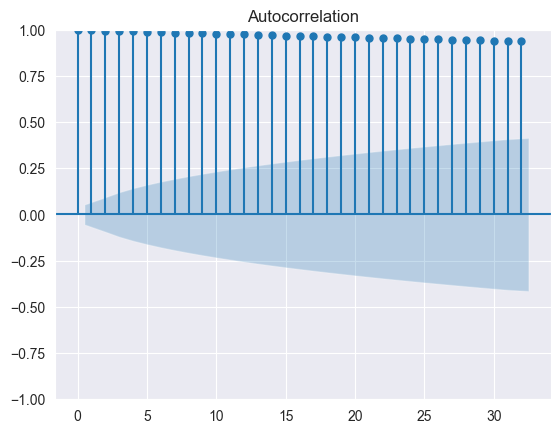

In [21]:
# Generate ACF plot
plot_acf(original_data['Nasdaq100']);

The ACF plot shows high and positive correlations with a slow decay, it suggests that the time series is not stationary and there is a strong autocorrelation in the time series.

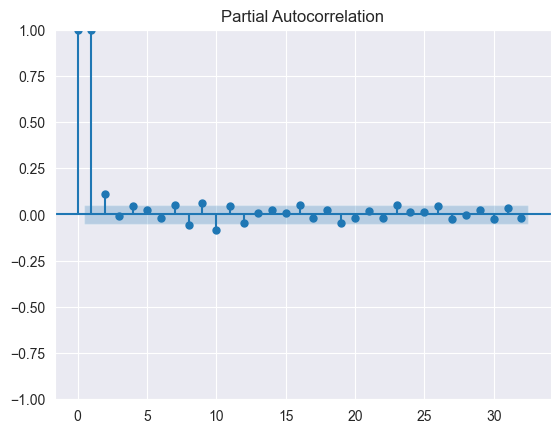

In [22]:
# Generate PACF plot
plot_pacf(original_data['Nasdaq100'], method="yw");

The PACF has spikes. Again, this indicates that there is a high correlation between the values at those lags and the time series is non-stationary.

# Model 1: ARIMA

## What is `ARIMA`
`ARIMA` (Autoregressive Integrated Moving Average) is a popular statistical model used for time series forecasting. It is a combination of three components: Autoregression (`AR`), Integration (`I`), and Moving Average (`MA`).

The AR component models the relationship between the current observation and a lagged observation(s) in the time series.
The `I` component deals with the non-stationarity of the time series and aims to transform the time series into a stationary one through differencing.
The `MA` component models the relationship between the current observation and the residual errors of the past observations.
`ARIMA` models can handle a wide range of time series data, including non-stationary data. They are widely used in finance, economics, and other fields to forecast stock prices, sales, and other time series data.

In this project, we will be using the `ARIMA` model to forecast the future values of the NASDAQ100 index based on its historical data.

## Data Preparation and Cleaning for ARIMA case

From the EDA in the previous section, we found that the timeseries is not stationary, and we need to perform transformation on the timeseries to make it stationary.

## Splitting the data into train and test set

Before transforming our data to stationary, we split it into training and test sets to prevent information leakage between the two sets. We chose to split the data based on the year 2023, where the training set consists of all the data up to and including 2022, and the test set contains all the data from 2023 onwards.

In [23]:
# split into training and testing sets with daily frequency
train_data = original_data[:-62]
test_data = original_data[-62:]

In [24]:
train_data

,Nasdaq100
Date,
2018-01-02,6511.34
2018-01-03,6575.80
2018-01-04,6584.58
2018-01-05,6653.29
2018-01-08,6676.63
...,...
2022-12-23,10985.45
2022-12-27,10822.51
2022-12-28,10679.34


In [25]:
test_data

,Nasdaq100
Date,
2023-01-03,10862.64
2023-01-04,10914.80
2023-01-05,10741.22
2023-01-06,11040.35
2023-01-09,11108.45
...,...
2023-03-27,12673.07
2023-03-28,12610.57
2023-03-29,12846.03


## Transform the timeseries to stationary - Differencing

We then tried to apply differencing techniques to improve the stationarity.

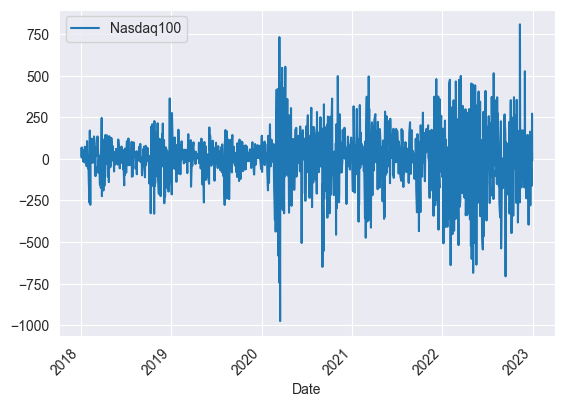

In [26]:
# transform the data using differencing
data_diff = train_data.diff().dropna()

# plot the transformed data
data_diff.plot()
plt.xticks(rotation=45)
plt.show()

Now the timeseries seems to be stationary as there is no obvious trend

## Test the stationarity of the transformed test set

### ADF test

In [27]:
# Perform ADF test on the differenced data
result = adfuller(data_diff['Nasdaq100'])

# Print the test statistic and p-value
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.522510
p-value: 0.000000


With the high negative value of the ADF statistic and p-value 0 < 0.05, we can reject the null hypothesis and conclude that the first-differenced time series is stationary, there is no need to proceed to second-order differencing.

### ADF and PACF plot

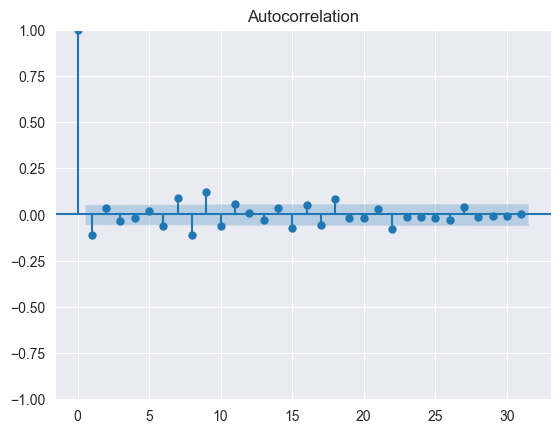

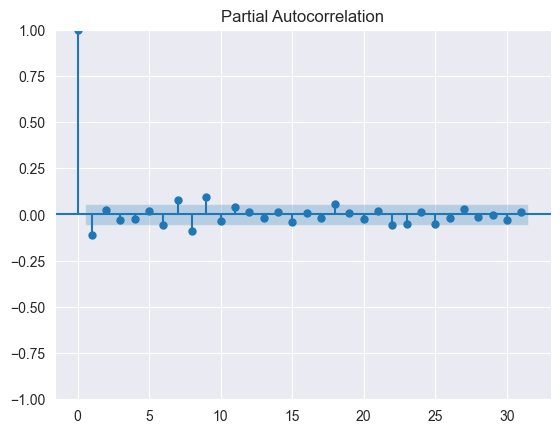

In [28]:
plot_acf(data_diff['Nasdaq100']);
plot_pacf(data_diff['Nasdaq100'], method="ywm");

There is only one significant spike in the ACF and PACF plots, it means that there is only one lag that has a strong correlation with the current observation, which can be an indication of stationarity.

## Determine ARIMA model parameters
From the previous section, we then decided on the parameters `(p , I , q) = (1 , 1 , 1)`. Here are the reasons:
1. The ACF plot shows a significant spike at the first lag, which suggests that an autoregressive (AR) model may be appropriate.

2. The PACF plot also shows significant spikes at the first lag, which suggests that a moving average (MA) component may be appropriate.

3. Data is stationary after first order differencing (`i=1`), an integrated (`I`) component is needed in the model.

Based on the above information, it seems reasonable to try a model with `p=1` and `q=1` and `I=1`.

## Build and fit the model

To obtain better predictions for our time series data, we developed two ARIMA models: an auto ARIMA model, which uses algorithms to automatically select the order of the parameters, and a manual ARIMA model, which involves manually specifying the parameters based on analysis of the data. By comparing the performance of both models using metrics such as RMSE, MAE, and MAPE, we can choose the model that provides the most accurate forecasts.

## Manual ARIMA

In [29]:
model = ARIMA(train_data, order=(1,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Nasdaq100   No. Observations:                 1259
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8275.914
Date:                Sat, 22 Apr 2023   AIC                          16557.829
Time:                        22:06:48   BIC                          16573.241
Sample:                             0   HQIC                         16563.621
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3474      0.153     -2.267      0.023      -0.648      -0.047
ma.L1          0.2386      0.160      1.491      0.136      -0.075       0.552
sigma2       3.04e+04    824.063     36.887      0.000    2.88e+04     3.2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               390.03
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.97   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Auto ARIMA

In [30]:
auto_arima = pm.auto_arima(train_data, stepwise=False, seasonal=True)

In [31]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1259
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -8266.692
Date:                Sat, 22 Apr 2023   AIC                          16547.383
Time:                        22:06:52   BIC                          16583.344
Sample:                             0   HQIC                         16560.898
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.9015      9.654      0.404      0.686     -15.019      22.822
ar.L1         -0.9516      0.058    -16.413      0.000      -1.065      -0.838
ar.L2         -0.0707      0.030     -2.325      0.020      -0.130      -0.011
ar.L3         -0.0197      0.029     -0.691      0.490      -0.076       0.036
ar.L4         -0.0868      0.023     -3.769      0.000      -0.132      -0.042
ma.L1          0.8525      0.056     15.255      0.000       0.743       0.962
sigma2      3.029e+04    869.554     34.835      0.000    2.86e+04     3.2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               354.86
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               5.88   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prediction of the models

In [32]:
forecast_test = model_fit.forecast(len(test_data))   #manual
forecast_test_auto = auto_arima.predict(n_periods=len(test_data)) #auto

## Evaluating the accuracy of the models

In [33]:
#manual
mae = mean_absolute_error(test_data, forecast_test)
mape = mean_absolute_percentage_error(test_data, forecast_test)
rmse = np.sqrt(mean_squared_error(test_data, forecast_test))
print("Manual ARIMA")
print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

Manual ARIMA
mae: 1175.049652271434
mape: 0.09519969069895638
rmse: 1288.0245824280032


In [34]:
#auto
mae = mean_absolute_error(test_data, forecast_test_auto)
mape = mean_absolute_percentage_error(test_data, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(test_data, forecast_test_auto))

print("Auto ARIMA")
print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

Auto ARIMA
mae: 1117.7912584818753
mape: 0.09056531595604539
rmse: 1225.1446044331267


In [35]:
# Compare with moving_avg
print("Spearman's Rank Correlation between moving_avg")
# Calculate
forecast_test_array =np.array(forecast_test.values.tolist())
forecast_test_auto_array =np.array(forecast_test_auto.values.tolist())
rho, p = spearmanr(moving_avg, forecast_test)
rho_auto, p_auto = spearmanr(moving_avg, forecast_test_auto)
print("Manual ARIMA")
print("RHO: ", rho)
print("p:   ", p)
print("AUTO ARIMA")
print("RHO: ", rho_auto)
print("p:   ", p_auto)

Spearman's Rank Correlation between moving_avg
Manual ARIMA
RHO:  -0.02725174594756084
p:    0.8334705748709672
AUTO ARIMA
RHO:  0.7477273299589534
p:    2.899106027960668e-12


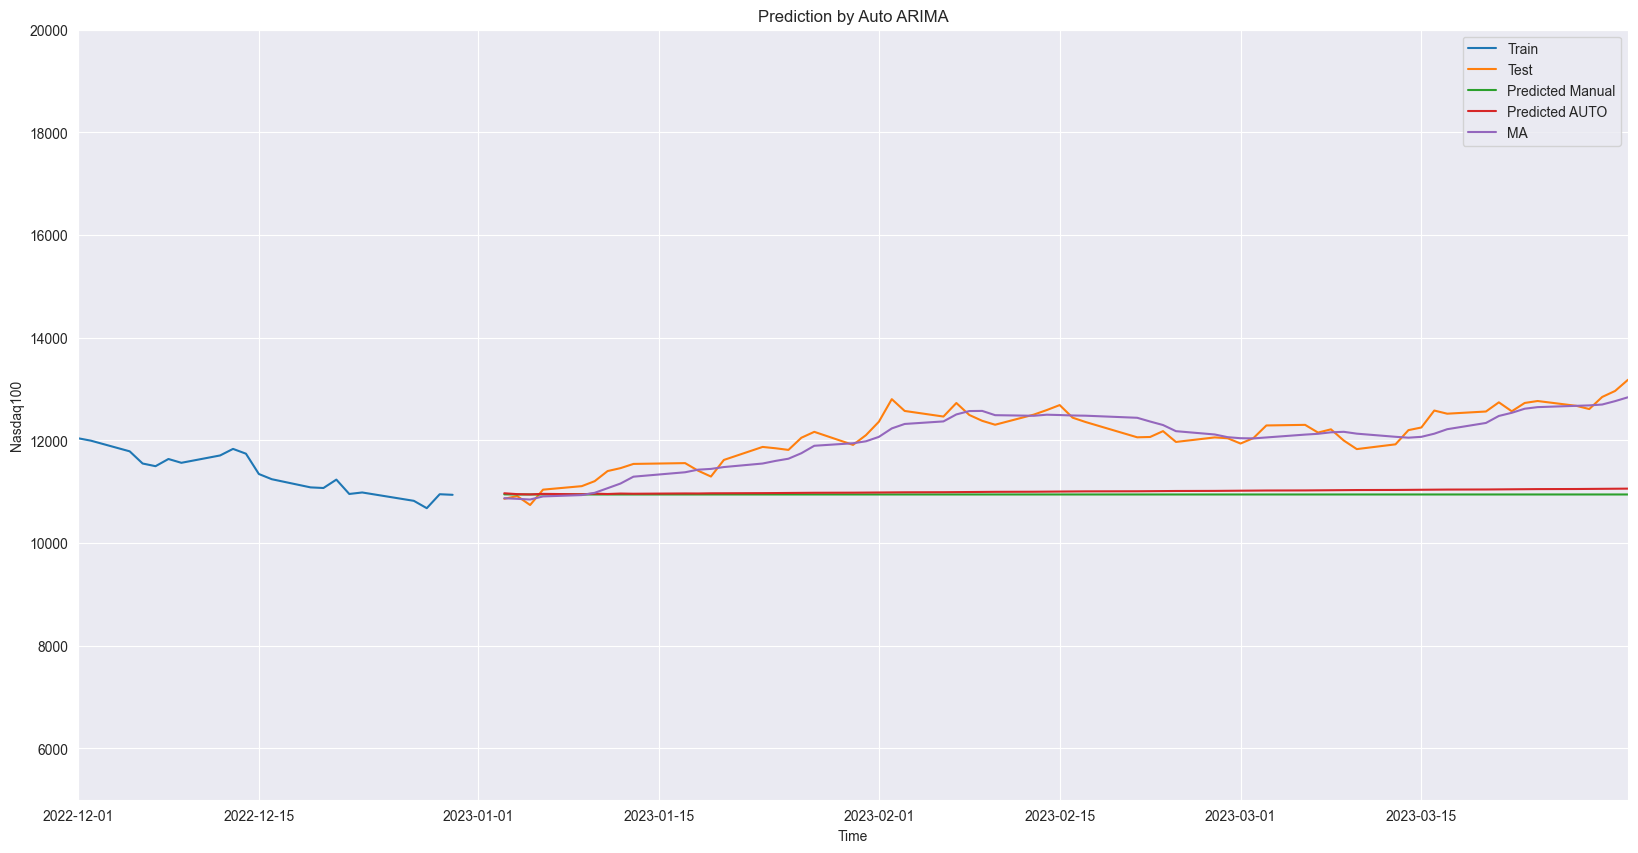

In [36]:
# set data range
plt.figure(figsize=(20,10))
dstart = datetime.datetime(2022,12,1)
dstop = datetime.datetime(2023,3,31)
plt.xlim(dstart,dstop)
plt.ylim(5000,20000)
plt.xlim(dstart,dstop)

# test['Predictions'] = predicted_price

train = original_data[:-62]
test = original_data[-62:]

test['Predictions'] =forecast_test_array
test['Predictions_AUTO'] =forecast_test_auto_array


# plot the datasets
plt.plot(train['Nasdaq100'], label='Train')
plt.plot(test['Nasdaq100'], label='Test')
plt.plot(test['Predictions'], label='Predicted Manual')
plt.plot(test['Predictions_AUTO'], label='Predicted AUTO')
plt.plot(MA_use['moving_avg_6'], label="MA")

# set the axis labels and title
plt.xlabel('Time')
plt.ylabel('Nasdaq100')
plt.title('Prediction by Auto ARIMA')
plt.grid(True)

# show the legend and the plot
plt.legend()
plt.show()

## Conclusion on ARIMA model

By observing the graph, we can see that the ARIMA models were able to capture the general range of the actual values. However,based on the Spearman's Rank Correlation between the predicted value and moving_avg. The trend was not accurately captured for both manual and auto ARIMA. This suggests that we may need to explore other modeling techniques, such as recurrent neural networks like LSTM, to better capture the complex non-linear trends present in the data. LSTM models are designed to effectively model patterns in time series data, and may be better suited for capturing the underlying trends in our dataset.

# Model 2: LSTM

## What is LSTM Model
`LSTM`, or `Long Short-Term Memory`, is a type of `recurrent neural network` (`RNN`) architecture designed to process and analyze sequential data such as speech, text, and time-series data.

LSTM was developed to overcome the limitations of traditional `RNNs`, which struggle to capture long-term dependencies in sequential data. The key difference between `LSTM` and other RNNs is that `LSTM` has a memory cell, which can store information for an extended period.

The `LSTM` cell consists of three gates - input gate, forget gate, and output gate - that control the flow of information through the cell. The input gate regulates the flow of new input into the memory cell, the forget gate decides what information to keep or discard, and the output gate determines what information to output from the memory cell.

The `LSTM` model can learn to selectively remember or forget information based on the task it is trained on, which makes it particularly useful for tasks such as speech recognition, natural language processing, and machine translation. It has been shown to be effective in various applications, including language modeling, speech recognition, and sentiment analysis.


### Read pure value from `original_data` and name it as `dataset`

In [37]:
dataset = original_data.values
dataset

array([[ 6511.34],
       [ 6575.8 ],
       [ 6584.58],
       ...,
       [12846.03],
       [12963.14],
       [13181.35]])

### Separate `train` and `test` data

In [38]:
train = dataset[0:-62,:]
test = dataset[-62:,:]

In [39]:
train

array([[ 6511.34],
       [ 6575.8 ],
       [ 6584.58],
       ...,
       [10679.34],
       [10951.05],
       [10939.76]])

In [40]:
test

array([[10862.64],
       [10914.8 ],
       [10741.22],
       [11040.35],
       [11108.45],
       [11205.78],
       [11402.53],
       [11459.61],
       [11541.48],
       [11557.19],
       [11410.29],
       [11295.67],
       [11619.03],
       [11872.54],
       [11846.64],
       [11814.69],
       [12051.48],
       [12166.6 ],
       [11912.39],
       [12101.93],
       [12363.1 ],
       [12803.14],
       [12573.36],
       [12464.51],
       [12728.27],
       [12495.38],
       [12381.17],
       [12304.92],
       [12502.31],
       [12590.89],
       [12687.89],
       [12442.48],
       [12358.18],
       [12060.3 ],
       [12066.27],
       [12180.14],
       [11969.65],
       [12057.79],
       [12042.12],
       [11938.57],
       [12044.87],
       [12290.81],
       [12302.48],
       [12152.17],
       [12215.33],
       [11995.88],
       [11830.28],
       [11923.17],
       [12199.79],
       [12251.32],
       [12581.39],
       [12519.88],
       [1256

### Scaling the data
- We scale our dataset to prevent certain features from dominating others and to ensure that the data is normalized, which can help the model converge faster during training.
- If the input data has a large range of values, it may be difficult for the `LSTM` model to learn the patterns and relationships within the data. Scaling the data can help mitigate this issue and improve the performance of the `LSTM` model.
- We choose `MinMaxScaler` to scale our dataset in to the range of `(0 , 1)`.
- `MinMaxScaler` is a commonly used data preprocessing technique in machine learning. The formula for MinMaxScaler is as follows:
- `X_scaled = (X - X_min) / (X_max - X_min)`
- we choose to use: `X_min = 0`, `X_max = 1`.
- Overall, using MinMaxScaler on a dataset before training an LSTM model can help improve the model's ability to learn and generalize patterns within the data.

In [41]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

### Generate `x_train` and `y_train`
- Because we want to predict the next `62` days in the future, so `x_train` is `62` days older than `y_train`.
- Thus, we are using `timestep = 62`.

In [42]:
timestep = 62
x_train, y_train = [], []
for i in range(timestep,len(train)):
	x_train.append(scaled_data[i-timestep:i,0])
	y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

### Create the `LSTM_1` Model using `timestep1=62`
- We are using a `2-layer` model.
- the parameter `units` refers to `the dimensionality of the output space`.
- For the reason of computer capability, we choose to use `units=50`.

In [43]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
model.summary()

1197/1197 - 12s - loss: 0.0031 - 12s/epoch - 10ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 62, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


### Prepare test data set `X_test`

In [44]:
inputs = data[len(data) - len(test) - 62:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(62,inputs.shape[0]):
	X_test.append(inputs[i-62:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

### Run Predict on `X_test` to get `predicted_price`

In [45]:
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)
print(type(predicted_price))
predicted_price

2/2 [==============================] - 0s 8ms/step
<class 'numpy.ndarray'>


array([[11219.263],
       [11186.008],
       [11166.868],
       [11141.99 ],
       [11144.062],
       [11167.793],
       [11211.908],
       [11282.952],
       [11369.391],
       [11465.612],
       [11560.93 ],
       [11633.739],
       [11676.196],
       [11726.895],
       [11800.538],
       [11878.564],
       [11949.759],
       [12033.029],
       [12126.256],
       [12192.844],
       [12256.358],
       [12336.092],
       [12459.52 ],
       [12575.097],
       [12666.532],
       [12760.74 ],
       [12824.218],
       [12853.279],
       [12851.531],
       [12850.057],
       [12855.958],
       [12874.611],
       [12875.234],
       [12857.954],
       [12802.801],
       [12731.359],
       [12666.771],
       [12591.178],
       [12525.095],
       [12468.607],
       [12413.296],
       [12374.315],
       [12371.673],
       [12391.728],
       [12410.018],
       [12432.646],
       [12434.795],
       [12409.615],
       [12379.483],
       [12374.639],


### Evaluation on LSTM Model

Compare with Original Data
MAE: 253.91753528225817
MAPE: 0.021069321412856504
RMSE: 321.27460731271145
Spearman's Rank Correlation between moving_avg
RHO:  0.950290851401375
p:    4.2512904109518616e-32


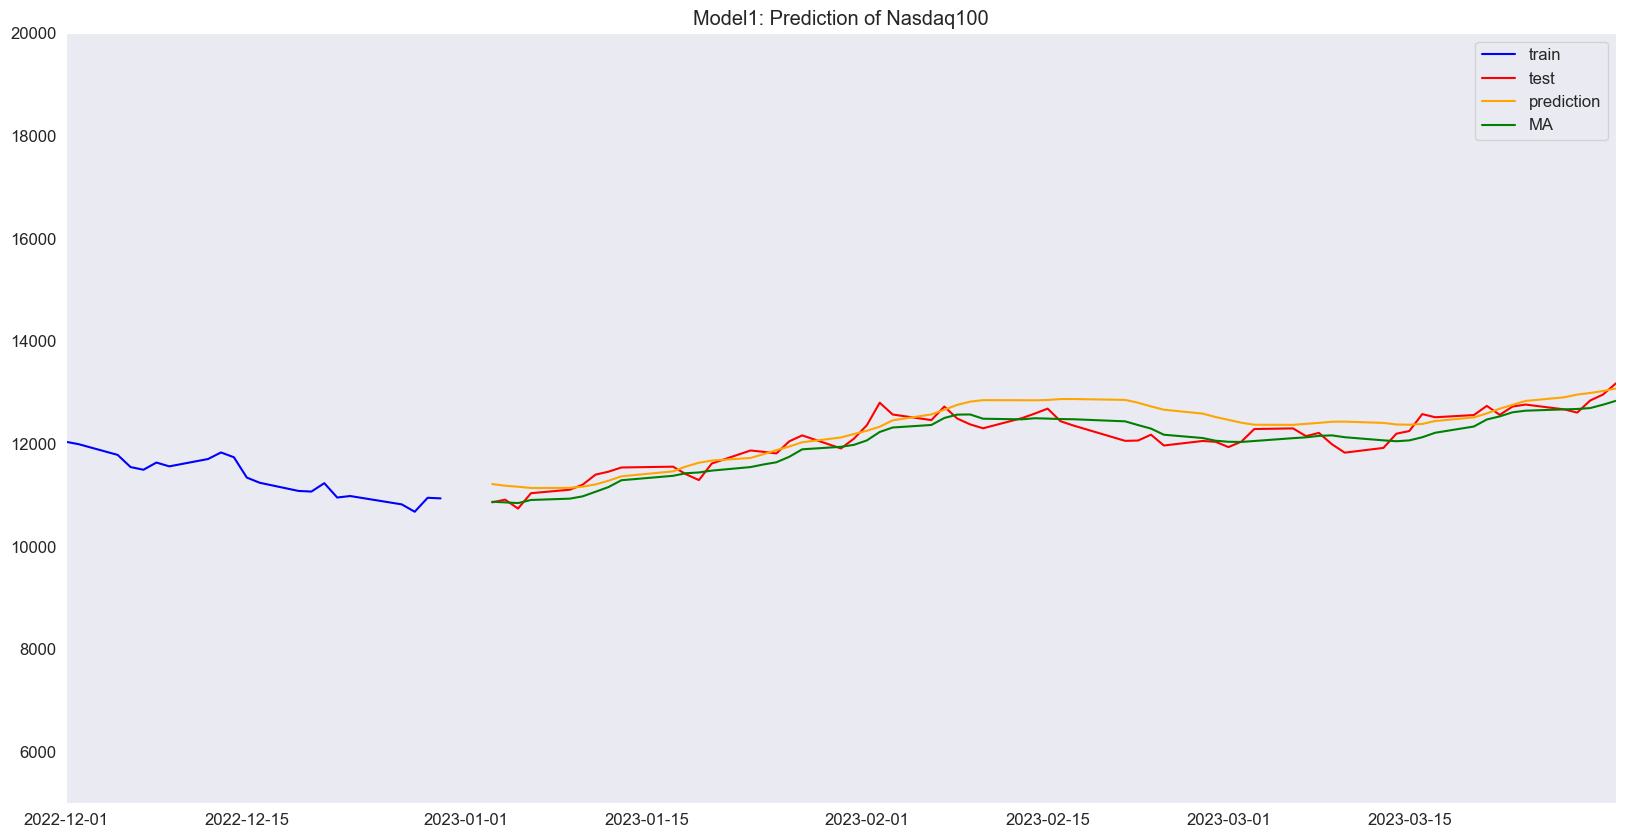

In [46]:
mae = mean_absolute_error(test, predicted_price)
mape = mean_absolute_percentage_error(test, predicted_price)
rmse = np.sqrt(mean_squared_error(test, predicted_price))
print("Compare with Original Data")
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')


# Compare with moving_avg
print("Spearman's Rank Correlation between moving_avg")
# Calculate
rho, p = spearmanr(moving_avg, predicted_price)
# print("")
print("RHO: ", rho)
print("p:   ", p)

plt.rc('font', size=12)
train = original_data[:-62]
test = original_data[-62:]
test['Predictions'] = predicted_price
plt.figure(figsize=(20,10))
plt.title("Model1: Prediction of Nasdaq100")
plt.grid()
plt.plot(train['Nasdaq100'],color="blue",label="train")
plt.plot(test['Nasdaq100'],color="red",label="test")
plt.plot(test['Predictions'],color="orange",label="prediction")
plt.plot(MA_use['moving_avg_6'], color="green", label="MA")
plt.legend()
dstart = datetime.datetime(2022,12,1)
dstop = datetime.datetime(2023,3,31)
plt.xlim(dstart,dstop)
plt.ylim(5000,20000)
plt.xlim(dstart,dstop)
plt.legend()
plt.show()

## Conclusion on `LSTM` model

From the above chart and plot, we can observe that:
    - `MAPE` the Mean Absolute Percentage Error is quite low, less than 0.05. This means that the difference between the predicted value and the true value is very small.
    - `MAE` and `RMSE` are both bigger than `200` but less than `300`. They seem to be large, but our data range is bigger than `10000`, which means `MAE` and `RMSE` are relatively quite small, around `2.5%`.
    - For Spearman's Rank Correlation between `predicted_value` and `moving_avg`, the `rho` is quite high, bigger than `0.90` and `p-value` is very small, its first significant digit starts from ten to the minus thirty power(a.k.a `e-30`).
    - For this model, `rho` is bigger than `0.9`, which is a very strong positive correlation. This means that as one variable increases in rank, the other variable tends to increase in rank as well.
    - The `p-value` is very small, which is much smaller than the usual level of significance. This suggests that there is strong evidence against the null hypothesis of no correlation between the two variables.
    - So that we can conclude that the correlation is statistically significant.
Therefore, We can say that, the `LSTM` model can predict the price and the trend of the `Nasdaq100` in the next `62` days in the future.


# Conclusion

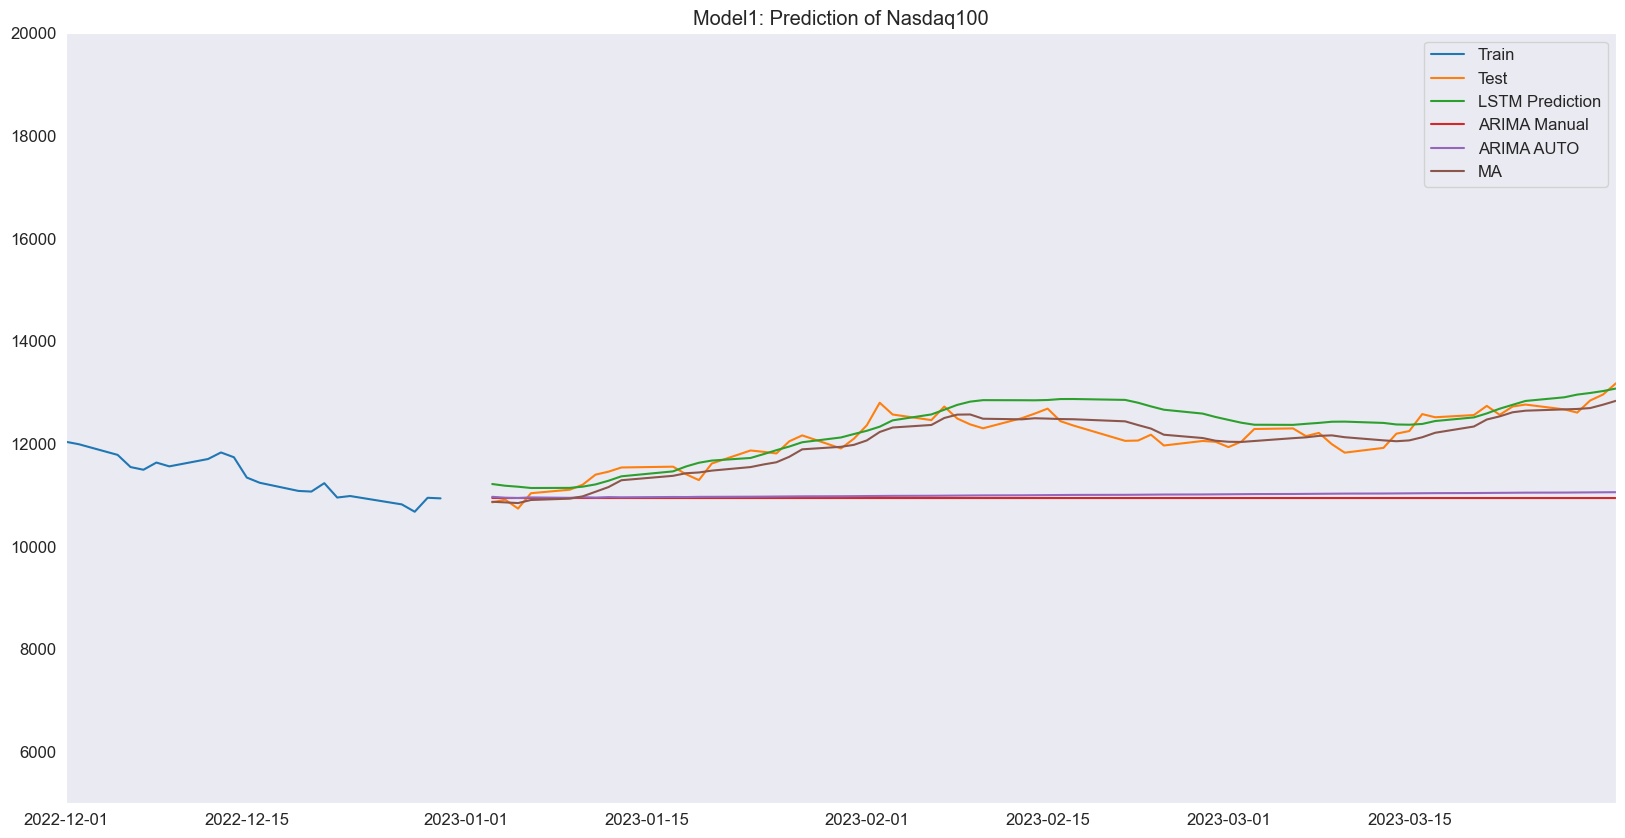

In [47]:
plt.rc('font', size=12)
train = original_data[:-62]
test = original_data[-62:]
test['L_Predictions'] = predicted_price
test['Predictions'] =forecast_test_array
test['Predictions_AUTO'] =forecast_test_auto_array

plt.figure(figsize=(20,10))
plt.title("Model1: Prediction of Nasdaq100")
plt.grid()
plt.plot(train['Nasdaq100'],label="Train")
plt.plot(test['Nasdaq100'],label="Test")
plt.plot(test['L_Predictions'],label="LSTM Prediction")
plt.plot(test['Predictions'], label='ARIMA Manual')
plt.plot(test['Predictions_AUTO'], label='ARIMA AUTO')
plt.plot(MA_use['moving_avg_6'], label="MA")
plt.legend()
dstart = datetime.datetime(2022,12,1)
dstop = datetime.datetime(2023,3,31)
plt.xlim(dstart,dstop)
plt.ylim(5000,20000)
plt.xlim(dstart,dstop)
plt.legend()
plt.show()

## Conclusion

Based on the results you have provided, it appears that the LSTM model outperforms both the manual and auto ARIMA models in terms of MAE, MAPE, RMSE, and Spearman's Rank Correlation with the moving average line. Specifically, the LSTM model has a much lower MAE and RMSE compared to both ARIMA models, and a much higher Spearman's Rank Correlation with the moving average line, indicating a stronger relationship between the predicted values and the actual values.

Therefore, it is reasonable to conclude that the LSTM model is the most effective model for predicting the trend of the Nasdaq100 index. While it may not be able to predict the exact price of the day with great accuracy, its ability to predict the trend is significant and its prediction errors are relatively small. Overall, the use of LSTM model has successfully solved the problem of predicting the price and trend of the Nasdaq100 index.

We can conclude that, we managed to solve our problem. That is, we successfully predict the price and the trend of `Nasdaq100`, using `LSTM` model.


# Data-Driven Insight

- Market trends are influenced by a variety of factors, including economic indicators, global events, and investor sentiment. By analyzing historical price data using sophisticated AI models, it is possible to identify patterns and make predictions about future market movements.

- The use of both `ARIMA` and `LSTM` models suggests that different approaches to time series analysis can be complementary and lead to more accurate predictions. `ARIMA` models are good at capturing linear trends and seasonal patterns, while `LSTM` models are well-suited for identifying non-linear patterns and long-term dependencies.

- The fact that our project was able to make successful predictions about the future price and trend of `Nasdaq100` suggests that there are predictable patterns in the market that can be leveraged for financial gain. However, it is important to note that market predictions are never `100%` accurate, and there is always a degree of risk involved in financial decision making.

- The success of our project also highlights the importance of data-driven decision making in financial markets. By leveraging machine learning and other AI techniques to analyze large amounts of data, investors and traders can make more informed decisions and potentially achieve higher returns.